In [1]:
# This is a model of a foveating neural network
# it reads text from images and produces a list of ascii characters

# E. Culurciello, February 2023

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import matplotlib.pyplot as plt
import pytesseract

import torch
import torch.nn as nn
from torchvision import transforms
import timm

/home/trungbui/doc_processor/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


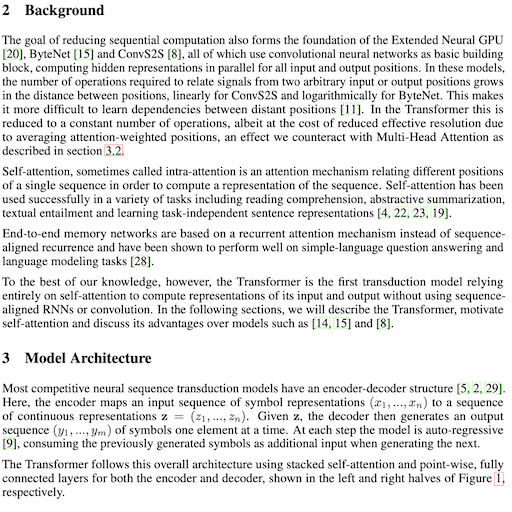

2 Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU
{20}, ByteNet [15] and Conv$2S [8], all of which use convolutional neural networks as basic building
block, computing hidden representations in parallel forall input and output postions. In these models,
the number of operations required to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for Conv2S and logarithmically for Byt ...


In [2]:
# we load an image crop of some paper and extract text with regular OCR
# this creates the dataset

im_size = (512,512)
page1 = Image.open('./train/attention-crop.png')
page1 = page1.resize(im_size)
display(page1)
transcript = pytesseract.image_to_string(page1)
print(transcript[:500], "...")

torch.Size([2567]) tensor(10) tensor(126)


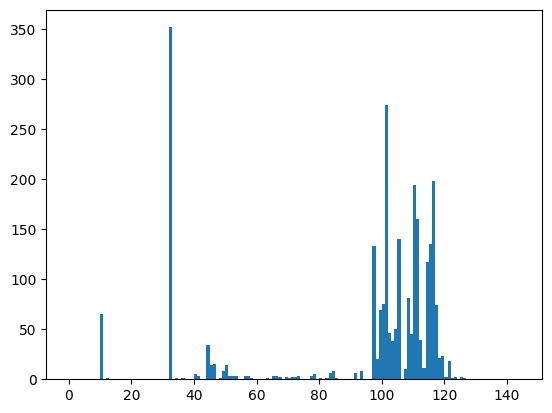

In [3]:
# convert the transcript to ascii values
# print(ord('?')) --> 63 # finding out what code is '?'
ascii_values=[]
for char in transcript:
    v = ord(char) if ord(char) < 144 else 63 # limit character to 144, set to '?' others
    ascii_values.append(v)

ascii_tensor = torch.tensor(ascii_values)
print(ascii_tensor.shape, ascii_tensor.min(), ascii_tensor.max())

# ascii_counts = torch.zeros(8213)
# for i in ascii_tensor:
#     ascii_counts[i] += 1

counts = plt.hist(ascii_tensor, bins=144, range=(0,144))
# plt.plot(ascii_counts[0:200])

In [4]:
# non-foveated model
# reader: sequence to sequence model
# input is page scanned encoded sequence
# output is ascii encoded sequence

class ReaderS2S(nn.Module):
    def __init__(self, im_size=224, ascii_num=144):
        super(ReaderS2S, self).__init__()
        self.im_size = im_size
        self.page_encoder = timm.create_model('vit_base_patch16_224', pretrained=False) # load ViT-B/16
        self.page_encoder.head = nn.Identity() # remove the classification head
        self.transformer = nn.Transformer(d_model=768,
                                          nhead=4, 
                                          num_encoder_layers=1,
                                          num_decoder_layers=1,
                                          dim_feedforward=768,
                                          batch_first=True)
        self.out_embedder = nn.Embedding(144, 768) # need to embed these characters ascii code to 768 dim
        self.decode_out = nn.Linear(768, ascii_num)

    def forward(self, image_in, seq_out):
        # scan image by moving encoder ViT by 224/2 pixels
        encoder_page_features = []
        for j in range(0, image_in.shape[1]-self.im_size, self.im_size//2):
            for i in range(0, image_in.shape[2]-self.im_size, self.im_size//2):
                image_crop = transforms.functional.crop(image_in, i, j, self.im_size, self.im_size)
                encoder_page_features.append(self.page_encoder(image_crop.unsqueeze(0)))

        # this is the encoder page sequence:
        encoder_page_features = torch.cat(encoder_page_features, dim=0).unsqueeze(0)
        # print(encoder_page_features.shape, seq_out.shape)

        # send to sequence transformer encoder
        seq_out_emb = self.out_embedder(seq_out)
        encoded_seq = self.transformer(encoder_page_features, seq_out_emb)
        output_seq = self.decode_out(encoded_seq)
        
        return output_seq

# # test model
# model = ReaderS2S()
# print(out_seq.shape)
# emb = model(page1, out_seq)
# print(emb.shape)

In [5]:
model = ReaderS2S()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

page_tensor = transforms.ToTensor()(page1)[:3]
train_dataset = [(page_tensor, ascii_tensor.unsqueeze(0)),]

def train():
    model.train()
    for epochs in range(10):
        for (inputs, targets) in train_dataset:
            optimizer.zero_grad()
            out = model(inputs, targets)
            loss = criterion(out.squeeze(0), targets.squeeze(0))
            loss.backward()
            optimizer.step()
            print('loss =', loss.item())

train()

KeyboardInterrupt: 

In [28]:
# test model
model.eval()
with torch.no_grad():
    out = model(page_tensor, ascii_tensor.unsqueeze(0))
    out = out.squeeze(0).squeeze(0)
    print(out.shape)

for c in out:
    print(chr(c.argmax()), end='')

torch.Size([2518, 144])
2 eackground

The goal of reducing sequential computation also forms the foundation of the ektended Neural ,,r
,2rn, eyteNet [1b] and ionvo2S [b], all of which use convolutional neural networks as basic building
block, computing hidden representations in parallel forall input and output postions. ,n these models,
the mimber of operations required to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ionvS2S and logarithmically for eyteNet. This makes
it more difficult to learn dependencies between distant positions [11]. ,n the Transformer this is
reduced to a constant number of operations, albeit atthe cost of reduced effective resolution due
to averaging attention-weighted positions, an effect we counteract with bulti-,ead fttention as
described in section 3.2,

Self-attention, sometimes called intra-attention isan attention mechanism relating different positions
of a single sequence in order to co